In [1]:
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.contrib.eager as tfe
import cv2
from keras.utils import plot_model
from tqdm import tqdm_notebook
import time
import pickle

/misc/me/pratikm/virtualEnv/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
tf.enable_eager_execution()

## Global variables

In [3]:
DIR_TFRECORDS = 'data_tfrecords'
DATA_TRAIN = sorted(glob('./'+DIR_TFRECORDS+'/train/*.tfrecords'), key=lambda s: s.lower())
DATA_EVAL = sorted(glob('./'+DIR_TFRECORDS+'/eval/*.tfrecords'), key=lambda s: s.lower())
DATA_TEST = sorted(glob('./'+DIR_TFRECORDS+'/test/*.tfrecords'), key=lambda s: s.lower())
IMG_H, IMG_W = 128, 128
THRESHOLD = 0.5

NUM_EPOCHS = 100
BATCH_SIZE = 16

DIR_CHECKPOINT = 'checkpoints_segmentation'
DIR_LOG = 'logs_segmentation'
INTERVAL_SUMMARY = 10
INTERVAL_LOG = 5

## Utility functions

In [4]:
# parses tfrecord file
def parse_record(record):
    # dictionary as per saved TFRecord
    keys_to_features = {
        'img': tf.FixedLenFeature(shape=(), dtype=tf.string),
        'mask': tf.FixedLenFeature(shape=(), dtype=tf.string),
        'idx_class': tf.FixedLenFeature(shape=(), dtype=tf.string)
    }

    # parse record
    parsed = tf.parse_single_example(record, keys_to_features)

    # decode image
    img = tf.decode_raw(parsed['img'], tf.uint8)
    img = tf.cast(tf.reshape(img, [IMG_H, IMG_W, 3]), tf.float32)
    img /= 255.  # normalize

    # decode mask
    mask = tf.decode_raw(parsed['mask'], tf.uint8)
    mask = tf.cast(tf.reshape(mask, [IMG_H, IMG_W]), tf.float32)
    mask /= 255.  # normalize
    
    # decode label
    label = tf.decode_raw(parsed['idx_class'], tf.float32)
    label = tf.squeeze(label)

    return img, label, mask

In [5]:
def compute_accuracy(preds, gt):
    masks_pred = preds > THRESHOLD
    masks_gt = gt > THRESHOLD
    
    # pixel accuracy
    accuracy = tf.reduce_mean(tf.cast(tf.equal(masks_pred, masks_gt), tf.float32))
    
    return accuracy

## Model

In [6]:
class SegNet(tf.keras.Model):
    def __init__(self):
        super(SegNet, self).__init__()
        self.optimizer = tf.train.AdamOptimizer()
        
        # add layers
        self.conv1 = tf.keras.layers.Conv2D(32, 3, padding='same', use_bias=False)
        self.norm1 = tf.keras.layers.BatchNormalization()
        self.pool1 = tf.keras.layers.MaxPool2D()

        self.conv2 = tf.keras.layers.Conv2D(64, 3, padding='same', use_bias=False)
        self.norm2 = tf.keras.layers.BatchNormalization()
        self.pool2 = tf.keras.layers.MaxPool2D()
        
        self.conv3 = tf.keras.layers.Conv2D(128, 3, padding='same', use_bias=False)
        self.norm3 = tf.keras.layers.BatchNormalization()
        self.pool3 = tf.keras.layers.MaxPool2D()
        
        self.conv4 = tf.keras.layers.Conv2D(128, 1, padding='same', use_bias=False)
        self.norm4 = tf.keras.layers.BatchNormalization()
        self.pool4 = tf.keras.layers.MaxPool2D()
        
        self.conv5 = tf.keras.layers.Conv2D(256, 1, padding='same', use_bias=False)
        self.norm5 = tf.keras.layers.BatchNormalization()
        self.pool5 = tf.keras.layers.MaxPool2D()
        
        self.convt6 = tf.keras.layers.Conv2DTranspose(256, 1, padding='same', use_bias=False)
        self.norm6 = tf.keras.layers.BatchNormalization()
        
        self.convt7 = tf.keras.layers.Conv2DTranspose(128, 1, padding='same', use_bias=False)
        self.norm7 = tf.keras.layers.BatchNormalization()
        
        self.convt8 = tf.keras.layers.Conv2DTranspose(128, 1, padding='same', use_bias=False)
        self.norm8 = tf.keras.layers.BatchNormalization()
        
        self.convt9 = tf.keras.layers.Conv2DTranspose(64, 3, padding='same', use_bias=False)
        self.norm9 = tf.keras.layers.BatchNormalization()
        
        self.convt10 = tf.keras.layers.Conv2DTranspose(32, 3, padding='same', use_bias=False)
        self.norm10 = tf.keras.layers.BatchNormalization()
        
        self.convt11 = tf.keras.layers.Conv2DTranspose(1, 1, padding='same')
        self.norm11 = tf.keras.layers.BatchNormalization()
        
    def forward(self, imgs):
        # imgs.shape = [B, IMG_H, IMG_W, 3]
        
        x = self.conv1(imgs)
        x = self.norm1(x)
        x = tf.nn.leaky_relu(x)
        x1 = self.pool1(x)
        
        x = self.conv2(x1)
        x = self.norm2(x)
        x = tf.nn.leaky_relu(x)
        x2 = self.pool2(x)
        
        x = self.conv3(x2)
        x = self.norm3(x)
        x = tf.nn.leaky_relu(x)
        x3 = self.pool3(x)
        
        x = self.conv4(x3)
        x = self.norm4(x)
        x = tf.nn.leaky_relu(x)
        x4 = self.pool4(x)
        
        x = self.conv5(x4)
        x = self.norm5(x)
        x = tf.nn.leaky_relu(x)
        x = self.pool5(x)
        
        x = tf.image.resize_images(x, tf.shape(x)[1:3]*tf.constant([2, 2]))
        x = self.convt6(x)
        x = self.norm6(x)
        x6 = tf.nn.leaky_relu(x)
        
        # concat 4 & 6
        x = tf.concat([x4, x6], axis=-1)
        
        x = tf.image.resize_images(x, tf.shape(x)[1:3]*tf.constant([2, 2]))
        x = self.convt7(x)
        x = self.norm7(x)
        x7 = tf.nn.leaky_relu(x)
        
        # concat 3 & 7
        x = tf.concat([x3, x7], axis=-1)
        
        x = tf.image.resize_images(x, tf.shape(x)[1:3]*tf.constant([2, 2]))
        x = self.convt8(x)
        x = self.norm8(x)
        x8 = tf.nn.leaky_relu(x)
        
        # concat 2 & 8
        x = tf.concat([x2, x8], axis=-1)
        
        x = tf.image.resize_images(x, tf.shape(x)[1:3]*tf.constant([2, 2]))
        x = self.convt9(x)
        x = self.norm9(x)
        x9 = tf.nn.leaky_relu(x)
        
        # concat 1 & 9
        x = tf.concat([x1, x9], axis=-1)
        
        x = tf.image.resize_images(x, tf.shape(x)[1:3]*tf.constant([2, 2]))
        x = self.convt10(x)
        x = self.norm10(x)
        x = tf.nn.leaky_relu(x)
        
        x = self.convt11(x)
        x = self.norm11(x)
        
        # compute output
        pred = tf.nn.sigmoid(tf.reshape(x, [-1, IMG_H, IMG_W]))
        
        return pred
    
    def get_loss(self, predictions, labels):
        predictions = tf.reshape(predictions, [-1, IMG_H*IMG_W])
        labels = tf.reshape(labels, [-1, IMG_H*IMG_W])
        loss = tf.losses.log_loss(labels, predictions)
        return loss
    
    def train(self, dataset, global_step):
        '''trains the model for one epoch'''
        
        accuracy = tfe.metrics.Mean('accuracy')
        avg_loss = tfe.metrics.Mean('loss')
        time_start = time.time()
        
        for idx_batch, data in enumerate(dataset):
            with tf.contrib.summary.record_summaries_every_n_global_steps(
                INTERVAL_SUMMARY, global_step=global_step):
                with tfe.GradientTape() as tape:
                    # forward pass
                    predictions = self.forward(data[0])
                    
                    # compute loss
                    loss = self.get_loss(predictions, data[2])
                    avg_loss(loss)
                    tf.contrib.summary.scalar('loss', loss)
                    
                    # compute accuracy
                    accuracy(compute_accuracy(predictions, data[2]))
                    tf.contrib.summary.scalar('accuracy', accuracy.result())
                    
                # backward pass (compute gradients)
                gradients = tape.gradient(loss, self.variables)

                # update parameters
                self.optimizer.apply_gradients(zip(gradients, self.variables), global_step=global_step)
                
                # log
                if INTERVAL_LOG and idx_batch % INTERVAL_LOG == 0:
                    rate = INTERVAL_LOG / (time.time() - time_start)
                    print('Batch:{}\tLoss:{:.6f}\t{:.0f}steps/sec'.format(idx_batch, loss.numpy(), rate), end='\r')
                    time_start = time.time()
                    
        return avg_loss.result()
    
    def evaluate(self, dataset):
        '''Returns metrics on the dataset'''
        
        avg_loss = tfe.metrics.Mean('loss')
        accuracy = tfe.metrics.Mean('accuracy')
        
        for idx, data in enumerate(dataset):
            # evaluate
            predictions = self.forward(data[0])
            
            # compute loss
            loss = self.get_loss(predictions, data[2])
            avg_loss(loss)
            
            # compute accuracy
            accuracy(compute_accuracy(predictions, data[2]))
        
        print('Eval: loss={:.4f}, accuracy={:.4f}%\n'.format(avg_loss.result(), 100*accuracy.result()))
        
        with tf.contrib.summary.always_record_summaries():
            tf.contrib.summary.scalar('loss', avg_loss.result())
            tf.contrib.summary.scalar('accuracy', accuracy.result())
    
    def predict(self, imgs):
        '''predicts bboxes and draws them on the image'''
        # imgs.shape = [B, IMG_H, IMG_W, 3]
        
        # forward pass
        predictions = self.forward(imgs)
        
        # threshold for foreground
        masks = predictions > THRESHOLD
        
        return masks
    
    def load_classification_weights(self, dir_weights):
        for idx_layer, layer in enumerate(self.layers):
            # skip final layers
            if idx_layer > 14:
                break
            
            filename = dir_weights + '/{}'.format(idx_layer)
            with open(filename, 'rb') as file:
                weights = pickle.load(file)
            
            layer.set_weights(weights)
        
        print('classification weights loaded')

## Train

In [7]:
# training data
dataset_train = tf.data.TFRecordDataset(DATA_TRAIN)
dataset_train = dataset_train.map(parse_record)
dataset_train = dataset_train.shuffle(buffer_size=1024)
dataset_train = dataset_train.batch(BATCH_SIZE)

# evaluation data
dataset_eval = tf.data.TFRecordDataset(DATA_EVAL)
dataset_eval = dataset_eval.map(parse_record)
dataset_eval = dataset_eval.batch(BATCH_SIZE)

# test data
dataset_test = tf.data.TFRecordDataset(DATA_TEST)
dataset_test = dataset_test.map(parse_record)
dataset_test = dataset_test.batch(BATCH_SIZE)

In [8]:
# model
seg_net = SegNet()

# log
writer_train = tf.contrib.summary.create_file_writer(DIR_LOG+'/train', flush_millis=10000, name='train')
writer_eval = tf.contrib.summary.create_file_writer(DIR_LOG+'/eval', flush_millis=10000, name='eval')
global_step = tf.train.get_or_create_global_step()

# checkpoint
checkpoint = tfe.Checkpoint(model=seg_net, optimizer=seg_net.optimizer, global_step=global_step)
checkpoint.restore(tf.train.latest_checkpoint(DIR_CHECKPOINT))

In [9]:
# load weights when starting training from scratch (i.e. when no checkpoints are present)
if checkpoint.save_counter.numpy() == 0:
    for data in dataset_train:
        seg_net.forward(data[0])
        break
    seg_net.load_classification_weights('weights_classifier')

In [10]:
for epoch in tqdm_notebook(range(NUM_EPOCHS)):
    # train
    time_start = time.time()
    with writer_train.as_default():
        loss = seg_net.train(dataset_train, global_step)
    time_end = time.time()
    print('\nTrain: epoch #{} ({} total steps): {:.0f} sec/epoch | loss:{}'.format(checkpoint.save_counter.numpy()+1, global_step.numpy(), time_end-time_start, loss.numpy()))
    
    # eval
    with writer_eval.as_default():
        seg_net.evaluate(dataset_eval) 
    
    # save checkpoint
    checkpoint.save(file_prefix=os.path.join(DIR_CHECKPOINT, 'ckpt'))

HBox(children=(IntProgress(value=0), HTML(value='')))

Batch:365	Loss:0.128136	15steps/sec
Train: epoch #21 (7770 total steps): 27 sec/epoch | loss:0.16880963712527947
Eval: loss=0.3513, accuracy=87.0143%

Batch:365	Loss:0.183465	15steps/sec
Train: epoch #22 (8140 total steps): 26 sec/epoch | loss:0.16315669465709376
Eval: loss=0.3512, accuracy=86.6269%

Batch:365	Loss:0.122550	13steps/sec
Train: epoch #23 (8510 total steps): 26 sec/epoch | loss:0.1592435761077984
Eval: loss=0.3886, accuracy=85.7245%

Batch:365	Loss:0.135298	15steps/sec
Train: epoch #24 (8880 total steps): 26 sec/epoch | loss:0.15282400308831318
Eval: loss=0.3545, accuracy=87.3467%

Batch:365	Loss:0.110923	15steps/sec
Train: epoch #25 (9250 total steps): 26 sec/epoch | loss:0.14604913854115717
Eval: loss=0.3542, accuracy=86.9981%

Batch:365	Loss:0.137610	14steps/sec
Train: epoch #26 (9620 total steps): 26 sec/epoch | loss:0.14140966796391718
Eval: loss=0.3460, accuracy=87.2726%

Batch:365	Loss:0.199012	15steps/sec
Train: epoch #27 (9990 total steps): 26 sec/epoch | loss:0.

KeyboardInterrupt: 

## Predict

/misc/me/pratikm/virtualEnv/lib/python3.5/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


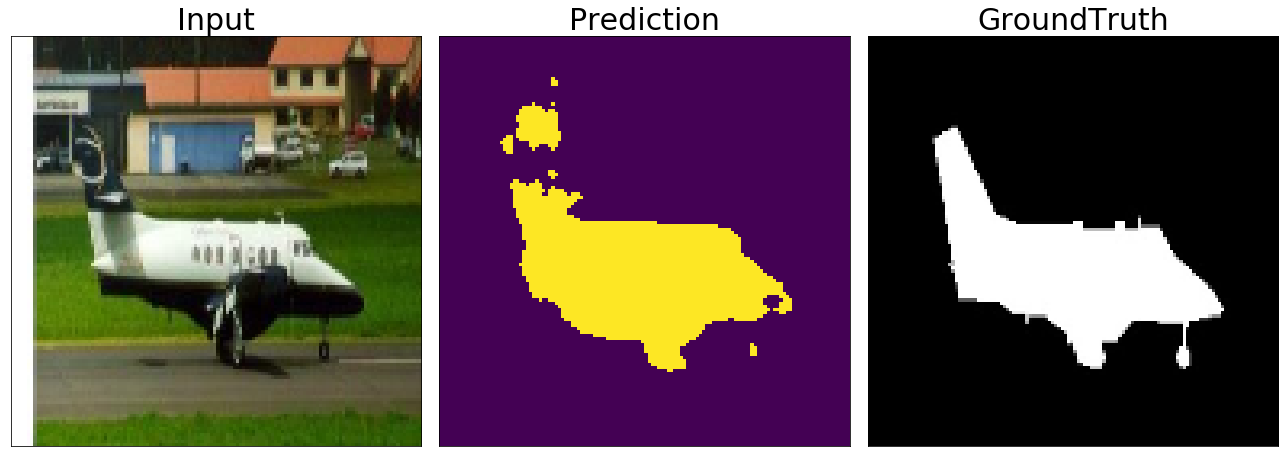

In [45]:
def process_img(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_W, IMG_H))
    img = (img / 255.).astype(np.float32)
    img = np.expand_dims(img, 0)
    
    return img

# read image
folder_name = 'airplanes'
idx = 17  # should be in range [11, 20]
img_path = '../test/input/{}/image_{:04}.jpg'.format(folder_name, idx)
img = cv2.imread(img_path)
img = process_img(img)

# read mask
mask_path = '../test/output/{}/image_{:04}.jpg'.format(folder_name, idx)
mask_gt = cv2.imread(mask_path)
mask_gt = cv2.resize(mask_gt, (IMG_W, IMG_H))

# load model
checkpoint.restore(tf.train.latest_checkpoint(DIR_CHECKPOINT))

# predict image
mask_pred = seg_net.predict(img)

# plot
fig, ax = plt.subplots(figsize=(18,8), nrows=1, ncols=3)

ax[0].imshow(img[0])
ax[0].set_title('Input', fontsize=30)
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)

ax[1].imshow(mask_pred[0])
ax[1].set_title('Prediction', fontsize=30)
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)

ax[2].imshow(mask_gt)
ax[2].set_title('GroundTruth', fontsize=30)
ax[2].get_xaxis().set_visible(False)
ax[2].get_yaxis().set_visible(False)

fig.tight_layout()
fig.show()
fig.savefig('{}.jpg'.format(folder_name))